In [3]:
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.3.20
    Uninstalling langgraph-0.3.20:
      Successfully uninstalled langgraph-0.3.20
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
%pip install python-dotenv langchain_groq langchain_ollama


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import getpass
import os
from dotenv import find_dotenv, load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
groq_api_key = os.getenv("groq_api_key")
os.environ["groq_api_key"] = groq_api_key 

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("groq_api_key")

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
tavily_api_key = os.getenv("tavily_api_key")
os.environ["tavily_api_key"] = tavily_api_key

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("tavily_api_key")

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
C:\Users\paulo\AppData\Local\Temp\ipykernel_15804\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\paulo\AppData\Local\Temp\ipykernel_15804\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [8]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder", "expenses_manager"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


#llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

#llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama-3.3-70b-Versatile")

MODEL_NAME = "llama3.2"
llm = ChatOllama(model=MODEL_NAME, temperature=0.5)
class State(MessagesState):
    next: str

    
call_count = 0
call_count_max = 2
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    global call_count  # Now it refers to the global variable
    global call_count_max

    call_count = call_count +1

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    if call_count  == call_count_max:
        goto = END

    return Command(goto=goto, update={"next": goto})

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    print("state:",state)
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    print("state:",state)
    result = code_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


import json
# Load the JSON file
file_path = "monthly_expenses.json"  # Replace with the correct path to your file
with open(file_path, "r") as file:
    data = json.load(file)

# Convert the JSON data to a string
monthly_expenses_json_string = json.dumps(data, indent=4)  # Pretty-printed string

expenses_manager_agent = create_react_agent(llm, tools=[],prompt=f"You are a expenses manager. you data is solely based here{monthly_expenses_json_string}")

def expenses_manager_node(state: State) -> Command[Literal["supervisor"]]:

    result = expenses_manager_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="expenses_manager")
            ]
         
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
builder.add_node("expenses_manager", expenses_manager_node)
graph = builder.compile()

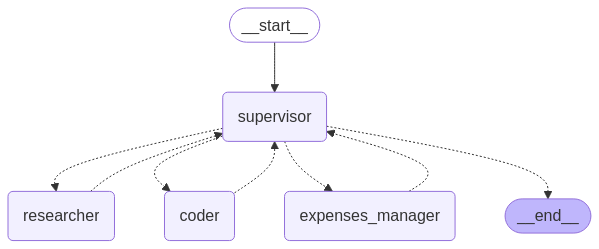

In [6]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
call_count = 0
call_count_max = 5
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
state: {'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='0f0eeed6-f5b1-497a-b53e-95aecf877645')], 'next': 'researcher'}
(('researcher:83adf8c1-7b4f-322b-8a6e-3d5123a75c1f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-31T08:39:27.9534993Z', 'done': True, 'done_reason': 'stop', 'total_duration': 522415500, 'load_duration': 65024100, 'prompt_eval_count': 205, 'prompt_eval_duration': 13000000, 'eval_count': 25, 'eval_duration': 436000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-cdf86f7f-e2d0-461a-9c9a-4029075f93c5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square root of 42'}, 'id': 'b1819746-3a38-4863-8f08-2610944ca4e4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 205, 'output_tokens': 25, 'total_t

In [13]:
call_count = 0
call_count_max = 5
events = graph.stream(
    {"messages": [("user", "Give me an insite on the spendings")]}, subgraphs=True
)


In [14]:
my_array = []
for s in events:
    print(s)
    my_array.append(s)
    print("----")

((), {'supervisor': {'next': 'expenses_manager'}})
----
(('expenses_manager:599dd5cd-9bac-7383-9573-86896c17753a',), {'agent': {'messages': [AIMessage(content="Based on the provided data, here's a summary of the expenses for each month in both 2023 and 2024:\n\n**2023**\n\n* Total Food Expenses: $80,000 (January) to $90,000 (December)\n\t+ Average monthly food expense: $8,333\n* Total Transport Expenses: $25,000 (January) to $30,000 (December)\n\t+ Average monthly transport expense: $2,500\n* Total Daily Expenses: $15,000 (January) to $20,000 (December)\n\t+ Average monthly daily expense: $1,500\n\n**2024**\n\n* Total Food Expenses: $85,000 (January) to $95,000 (December)\n\t+ Average monthly food expense: $8,500\n* Total Transport Expenses: $26,000 (January) to $31,000 (December)\n\t+ Average monthly transport expense: $2,600\n* Total Daily Expenses: $17,000 (January) to $22,000 (December)\n\t+ Average monthly daily expense: $1,700\n\n**Comparison with 2023**\n\n* Food expenses increa

In [15]:
my_array[0]


((), {'supervisor': {'next': 'expenses_manager'}})

In [70]:
my_array[0][1]['supervisor']['next']


'expenses_manager'

In [69]:
my_array[1][1]["agent"]["messages"][0].content  

"Based on the provided data, here's a summary of the expenses for each month in both 2023 and 2024:\n\n**2023**\n\n* Total Food Expenses: $80,000 (January) to $90,000 (December)\n\t+ Average monthly food expense: $8,333\n* Total Transport Expenses: $25,000 (January) to $30,000 (December)\n\t+ Average monthly transport expense: $2,500\n* Total Daily Expenses: $15,000 (January) to $20,000 (December)\n\t+ Average monthly daily expense: $1,500\n\n**2024**\n\n* Total Food Expenses: $85,000 (January) to $95,000 (December)\n\t+ Average monthly food expense: $8,500\n* Total Transport Expenses: $26,000 (January) to $31,000 (December)\n\t+ Average monthly transport expense: $2,600\n* Total Daily Expenses: $17,000 (January) to $22,000 (December)\n\t+ Average monthly daily expense: $1,700\n\n**Comparison with 2023**\n\n* Food expenses increased by 5.6% in 2024 compared to 2023.\n* Transport expenses decreased by 7.8% in 2024 compared to 2023.\n* Daily expenses increased by 13.3% in 2024 compared t

In [74]:
for i in range(len(my_array) - 1):
    try:
        if my_array[i][1]['supervisor']['next']:  # Check if 'next' key exists and is not empty
            print(my_array[i + 1][1]["agent"]["messages"][0].content)
            print("-----------")
    except (KeyError, IndexError, TypeError):
        print("")


Based on the provided data, here's a summary of the expenses for each month in both 2023 and 2024:

**2023**

* Total Food Expenses: $80,000 (January) to $90,000 (December)
	+ Average monthly food expense: $8,333
* Total Transport Expenses: $25,000 (January) to $30,000 (December)
	+ Average monthly transport expense: $2,500
* Total Daily Expenses: $15,000 (January) to $20,000 (December)
	+ Average monthly daily expense: $1,500

**2024**

* Total Food Expenses: $85,000 (January) to $95,000 (December)
	+ Average monthly food expense: $8,500
* Total Transport Expenses: $26,000 (January) to $31,000 (December)
	+ Average monthly transport expense: $2,600
* Total Daily Expenses: $17,000 (January) to $22,000 (December)
	+ Average monthly daily expense: $1,700

**Comparison with 2023**

* Food expenses increased by 5.6% in 2024 compared to 2023.
* Transport expenses decreased by 7.8% in 2024 compared to 2023.
* Daily expenses increased by 13.3% in 2024 compared to 2023.

**Trends and Insights*